### Experiment 4 summary:
1. import bird model ghi values
2. import actual data
3. merge the two based on the common timestamps
4. drop all rows if 'ghi' value is 0
5. ** DO NOT drop all rows with dw_solar < 0 **
6. Manage missing values: Drop any row if it has -9999.9
7. Make Kt column ('dw_solar'/'ghi') 
8. Group the data into hourly format (by finding mean)
9. assign hierarchical index
10. get the subdataframes for each day and shift the Kt values
11. drop the year, month, day, hour and minute columns
12. feed the data into RNN alrogithm
    - RNN seq_lenth = 1
    - learning rate = 0.001
    - single RNN layer
    - num of epochs = 5000

** in this experiment we are not giving Kt as one of the features. We are using hierarchical index to make sub dataframe for every day and then shift the Kt values one cell up to make it as one hour forecast. **

### NOTE
** the test['Kt'].max() values after grouping into hourly data is 7279.907547 = this is a outlier. The reason might be having a dw_solar reading with QC=2 value. Still haven't checked that. But the second highest value of 'Kt' parameter in the testset is 672 (which is way lower) **

In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
bod = Location(40.0150,-105.2705, 'US/Mountain', 1655.064, 'Boulder')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=bod.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=bod.tz)   # 24 months of 2010 and 2011 - For training
#times2011 = pd.DatetimeIndex(start='2011-01-01', end='2012-01-01', freq='1min',
                       # tz=bod.tz)   # 12 months of 2011  - For training

In [7]:
cs_2009 = bod.get_clearsky(times2009) 
cs_2010and2011 = bod.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bod.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-07:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-07:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-07:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-07:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-07:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Boulder\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1050018, 48)

In [18]:
path = r'.\\data\\Boulder\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(525132, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(3702, 48)

### Merging Clear Sky GHI And the big dataframe

In [24]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1050018, 50)

In [25]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(525132, 50)

In [26]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [27]:
df_train.shape

(1050018, 49)

### Managing missing values

In [28]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [29]:
# Dropping rows with two or more -9999.9 values in columns

In [30]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(1034397, 49)

In [31]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(505639, 49)

In [32]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [33]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [34]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [35]:
len(one_miss_train_idx)

10058

In [36]:
df_train.shape

(1034397, 49)

In [37]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
df_col_min = df_train.apply(min, axis=0)
df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [39]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [40]:
len(train)

0

In [41]:
# doing the same thing on test dataset

In [42]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

6657

In [43]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [44]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [45]:
len(test)

0

In [46]:
df_train.shape

(1034397, 49)

In [47]:
df_test.shape

(505639, 49)

### Exploratory Data Analysis

In [48]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

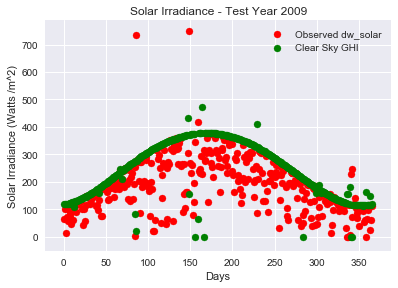

In [49]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


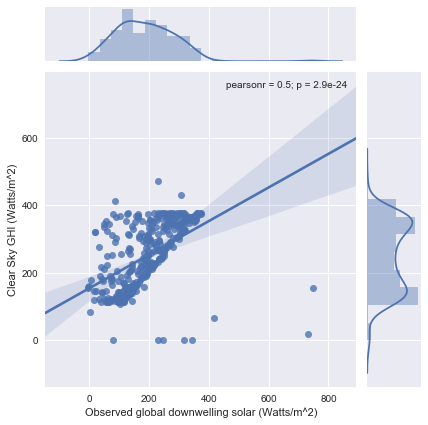

In [50]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure3.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [51]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [52]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [53]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 18622.003582590547
test Kt min: -1997.8414616673917
test Kt mean: 3.2082558853348537


train Kt max: 275783.5110086593
train Kt min: -1561.168664736838
train Kt mean: 3.977201231349393


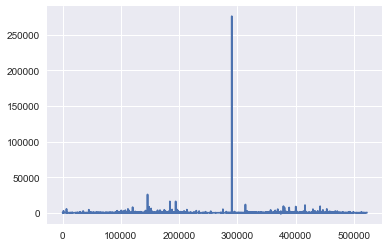

In [54]:
plt.plot(df_train['Kt'])

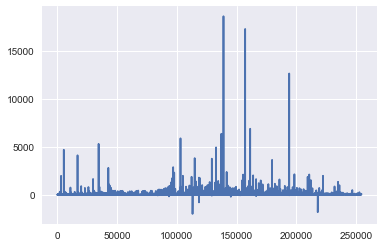

In [55]:
plt.plot(df_test['Kt'])

In [56]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

In [57]:
df_train.head()

,index,year,jday,month,day,hour,min,dt,zen,dw_solar,...,rh,rh_QC,windspd,windspd_QC,winddir,winddir_QC,pressure,pressure_QC,ghi,Kt
0,446,2010.0,1.0,1.0,1.0,7.0,26.0,7.433,162.31,-2.2,...,57.4,0.0,2.3,0.0,16.5,0.0,830.6,0.0,4.162896,-0.528478
1,447,2010.0,1.0,1.0,1.0,7.0,27.0,7.450,162.25,-2.2,...,58.5,0.0,2.6,0.0,13.7,0.0,830.6,0.0,8.593390,-0.256011
2,448,2010.0,1.0,1.0,1.0,7.0,28.0,7.467,162.19,-2.0,...,59.1,0.0,2.4,0.0,13.1,0.0,830.6,0.0,11.478161,-0.174244
3,449,2010.0,1.0,1.0,1.0,7.0,29.0,7.483,162.14,-1.8,...,59.7,0.0,2.7,0.0,14.5,0.0,830.6,0.0,13.503592,-0.133298
4,450,2010.0,1.0,1.0,1.0,7.0,30.0,7.500,162.07,-1.8,...,60.2,0.0,2.8,0.0,20.6,0.0,830.6,0.0,15.052006,-0.119585


#### Group the data (train dataframe)

In [58]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [59]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [60]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 7.0   161.031471 -2.950000 -0.711765  1.138235  0.538235   
                 8.0   155.139333 -3.753333 -0.936667  1.285000  0.513333   
                 9.0   145.065667 -3.293333 -0.251667  1.255000  0.488333   
                 10.0  133.892500 -3.641667 -0.710000  1.795000  0.406667   
                 11.0  122.454000 -3.126667 -0.471667  1.275000  0.456667   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 7.0   224.085294   270.364706   269.979412  268.744118   
                 8.0   223.563333   270.761667   270.405000  275.378333   
                 9.0   212.618333   270.150000   269.700000  273.045000   
                 10.0  215.475000   269.760000   269.403333  270.496667   
                 11.0  216.165000   269.116667   268.663333  269.205000   

                       uw_casetemp    ...     netsolar      netir   totalnet  \
year   month day hour                 ...                                      
2010.0 1.0   1.0 7.0    268.611765    ...          0.0 -44.652941 -44.652941   
                 8.0    269.453333    ...          0.0 -51.813333 -51.813333   
                 9.0    268.510000    ...          0.0 -60.421667 -60.421667   
                 10.0   267.760000    ...          0.0 -55.031667 -55.031667   
                 11.0   267.470000    ...          0.0 -53.050000 -53.050000   

                           temp         rh   windspd     winddir    pressure  \
year   month day hour                                                          
2010.0 1.0   1.0 7.0  -3.211765  56.261765  2.835294  107.311765  830.647059   
                 8.0  -2.645000  53.351667  3.866667  147.821667  830.728333   
                 9.0  -3.716667  59.238333  3.315000   63.578333  831.020000   
                 10.0 -3.923333  60.121667  3.076667   71.128333  831.073333   
                 11.0 -4.565000  61.175000  3.535000  184.166667  831.015000   

                              ghi        Kt  
year   month day hour                        
2010.0 1.0   1.0 7.0    33.080713 -0.116856  
                 8.0   143.676328 -0.030061  
                 9.0   299.581054 -0.011214  
                 10.0  419.749575 -0.008772  
                 11.0  486.001859 -0.006431  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [61]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [62]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [63]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
6.0,151.473333,-3.300000,-0.233333,-3.483333,-0.116667,233.200000,280.250000,279.550000,309.550000,279.016667,...,0.000000,-76.316667,-76.316667,6.783333,37.650000,3.866667,253.666667,820.400000,11.691876,-0.326406
7.0,151.355333,-3.783333,-1.331667,2.156667,-0.118333,232.493333,279.143333,278.730000,301.550000,278.228333,...,0.000000,-69.071667,-69.071667,6.888333,36.541667,2.335000,236.583333,819.853333,85.439689,-0.067258
8.0,147.215333,-3.510000,-1.576667,1.040000,-0.085000,228.316667,278.118333,277.690000,292.126667,276.498333,...,0.000000,-63.806667,-63.806667,5.211667,41.668333,1.003333,183.796667,819.033333,276.176482,-0.013317
9.0,139.073167,-4.836667,-1.441667,3.286667,0.153333,228.880000,278.088333,277.798333,301.906667,276.206667,...,0.000000,-73.030000,-73.030000,5.850000,36.901667,2.431667,154.540000,817.888333,459.734986,-0.010574
10.0,128.876667,-4.575000,-0.933333,0.893333,-0.031667,230.783333,278.736667,278.345000,308.195000,277.050000,...,0.000000,-77.415000,-77.415000,5.566667,34.063333,3.446667,180.726667,816.726667,599.596511,-0.007646
11.0,117.762500,-4.770000,-1.326667,2.743333,0.120000,241.015000,279.501667,279.201667,304.923333,277.420000,...,0.000000,-63.898333,-63.898333,6.798333,28.861667,1.726667,144.958333,816.071667,681.707415,-0.006993
12.0,106.328333,-4.698333,-1.208333,1.531667,0.030000,229.035000,280.325000,279.935000,312.165000,278.568333,...,0.000000,-83.126667,-83.126667,7.463333,28.286667,3.046667,217.635000,815.656667,699.157260,-0.006720
13.0,94.871333,-3.521667,0.295000,18.040000,1.958333,227.543333,280.648333,280.078333,324.303333,279.133333,...,1.470000,-96.761667,-95.290000,7.078333,32.360000,10.041667,249.865000,815.330000,650.549614,-0.005250
14.0,83.779333,78.048333,23.100000,542.223333,32.271667,230.468333,281.270000,280.663333,329.951667,278.816667,...,75.555000,-99.493333,-23.943333,6.751667,36.701667,9.171667,242.581667,815.920000,539.852805,0.152844


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [64]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [65]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-1)

In [66]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [67]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [68]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-1)

In [69]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [70]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
3.0,11.0,18.0,44.765833,815.241667,123.763333,1004.053333,79.721667,199.776667,277.12,276.648333,392.78,273.916667,...,668.746667,-193.015,475.741667,-1.26,50.875,2.656667,94.016667,833.296667,75.221941,1026.823214


### Normalize train and test dataframe

In [71]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [72]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [73]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


1

In [74]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [75]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [94]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 7.0   161.031471 -2.950000 -0.711765  1.138235  0.538235   
                 8.0   155.139333 -3.753333 -0.936667  1.285000  0.513333   
                 9.0   145.065667 -3.293333 -0.251667  1.255000  0.488333   
                 10.0  133.892500 -3.641667 -0.710000  1.795000  0.406667   
                 11.0  122.454000 -3.126667 -0.471667  1.275000  0.456667   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 7.0   224.085294   270.364706   269.979412  268.744118   
                 8.0   223.563333   270.761667   270.405000  275.378333   
                 9.0   212.618333   270.150000   269.700000  273.045000   
                 10.0  215.475000   269.760000   269.403333  270.496667   
                 11.0  216.165000   269.116667   268.663333  269.205000   

                       uw_casetemp    ...     netsolar      netir   totalnet  \
year   month day hour                 ...                                      
2010.0 1.0   1.0 7.0    268.611765    ...          0.0 -44.652941 -44.652941   
                 8.0    269.453333    ...          0.0 -51.813333 -51.813333   
                 9.0    268.510000    ...          0.0 -60.421667 -60.421667   
                 10.0   267.760000    ...          0.0 -55.031667 -55.031667   
                 11.0   267.470000    ...          0.0 -53.050000 -53.050000   

                           temp         rh   windspd     winddir    pressure  \
year   month day hour                                                          
2010.0 1.0   1.0 7.0  -3.211765  56.261765  2.835294  107.311765  830.647059   
                 8.0  -2.645000  53.351667  3.866667  147.821667  830.728333   
                 9.0  -3.716667  59.238333  3.315000   63.578333  831.020000   
                 10.0 -3.923333  60.121667  3.076667   71.128333  831.073333   
                 11.0 -4.565000  61.175000  3.535000  184.166667  831.015000   

                              ghi        Kt  
year   month day hour                        
2010.0 1.0   1.0 7.0    33.080713 -0.030061  
                 8.0   143.676328 -0.011214  
                 9.0   299.581054 -0.008772  
                 10.0  419.749575 -0.006431  
                 11.0  486.001859 -0.007064  

[5 rows x 23 columns]

In [77]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [78]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9400, 22)
y1_train shape is (9400,)
X2_test shape is (4300, 22)
y2_test shape is (4300,)


In [79]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [80]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [81]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [82]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [83]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        n_iter += 1  
            
        if n_iter%200 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
               

Epoch: 2 Iteration: 200. Train_MSE: 0.0022665311116725206. Test_MSE: 0.0004758805569397013
Epoch: 4 Iteration: 400. Train_MSE: 0.0013853006530553102. Test_MSE: 0.00048329754716710133
Epoch: 6 Iteration: 600. Train_MSE: 0.0012469941284507513. Test_MSE: 0.0004873524110060406
Epoch: 8 Iteration: 800. Train_MSE: 0.0015557525912299752. Test_MSE: 0.00048470089958382563
Epoch: 10 Iteration: 1000. Train_MSE: 0.0015303556574508548. Test_MSE: 0.00048251811680206604
Epoch: 12 Iteration: 1200. Train_MSE: 0.0008829520083963871. Test_MSE: 0.00047851106365711575
Epoch: 15 Iteration: 1400. Train_MSE: 0.001470720861107111. Test_MSE: 0.0004732242015260288
Epoch: 17 Iteration: 1600. Train_MSE: 0.0015222637448459864. Test_MSE: 0.00046849833108920827
Epoch: 19 Iteration: 1800. Train_MSE: 0.0010090837022289634. Test_MSE: 0.0004645333733951604
Epoch: 21 Iteration: 2000. Train_MSE: 0.001195061020553112. Test_MSE: 0.0004598670414216901
Epoch: 23 Iteration: 2200. Train_MSE: 0.0014515140792354941. Test_MSE: 0.00

Epoch: 191 Iteration: 17800. Train_MSE: 0.0005244762869551778. Test_MSE: 0.0003058307902814137
Epoch: 193 Iteration: 18000. Train_MSE: 0.0006711764144711196. Test_MSE: 0.00030407162032309107
Epoch: 195 Iteration: 18200. Train_MSE: 0.002515346510335803. Test_MSE: 0.0003031109595392716
Epoch: 197 Iteration: 18400. Train_MSE: 0.000518552609719336. Test_MSE: 0.00030249829273620816
Epoch: 199 Iteration: 18600. Train_MSE: 0.0006288933800533414. Test_MSE: 0.00030128028951644653
Epoch: 202 Iteration: 18800. Train_MSE: 0.0005897278897464275. Test_MSE: 0.0002995836674212437
Epoch: 204 Iteration: 19000. Train_MSE: 0.0007885417435318232. Test_MSE: 0.000299303710222433
Epoch: 206 Iteration: 19200. Train_MSE: 0.00042799607035703957. Test_MSE: 0.00029835253081570725
Epoch: 208 Iteration: 19400. Train_MSE: 0.0005792034207843244. Test_MSE: 0.0002963060749145437
Epoch: 210 Iteration: 19600. Train_MSE: 0.0005205718334764242. Test_MSE: 0.00029612764343043304
Epoch: 212 Iteration: 19800. Train_MSE: 0.00041

Epoch: 376 Iteration: 35000. Train_MSE: 0.00037763852742500603. Test_MSE: 0.00023648267742490015
Epoch: 378 Iteration: 35200. Train_MSE: 0.0003109891258645803. Test_MSE: 0.00023568193226295266
Epoch: 380 Iteration: 35400. Train_MSE: 0.0002954426745418459. Test_MSE: 0.00023458306207476803
Epoch: 382 Iteration: 35600. Train_MSE: 0.00047930952860042453. Test_MSE: 0.00023471596004918967
Epoch: 384 Iteration: 35800. Train_MSE: 0.000740390329156071. Test_MSE: 0.00023417245272701445
Epoch: 387 Iteration: 36000. Train_MSE: 0.0018943487666547298. Test_MSE: 0.0002330308208816669
Epoch: 389 Iteration: 36200. Train_MSE: 0.00041098546353168786. Test_MSE: 0.00023281868588157187
Epoch: 391 Iteration: 36400. Train_MSE: 0.0002990940702147782. Test_MSE: 0.0002325286898575487
Epoch: 393 Iteration: 36600. Train_MSE: 0.0003465164336375892. Test_MSE: 0.00023148363279727592
Epoch: 395 Iteration: 36800. Train_MSE: 0.002119992859661579. Test_MSE: 0.00023103697668385483
Epoch: 397 Iteration: 37000. Train_MSE: 0

Epoch: 561 Iteration: 52200. Train_MSE: 0.0003823031729552895. Test_MSE: 0.0001962718553038181
Epoch: 563 Iteration: 52400. Train_MSE: 0.004138375166803598. Test_MSE: 0.0001960623959696018
Epoch: 565 Iteration: 52600. Train_MSE: 0.00041552435141056776. Test_MSE: 0.00019509885267889678
Epoch: 567 Iteration: 52800. Train_MSE: 0.00038007981493137777. Test_MSE: 0.00019520321537990247
Epoch: 569 Iteration: 53000. Train_MSE: 0.001976546598598361. Test_MSE: 0.00019492609049793767
Epoch: 572 Iteration: 53200. Train_MSE: 0.00020537880482152104. Test_MSE: 0.00019432510873014215
Epoch: 574 Iteration: 53400. Train_MSE: 0.0008028798620216548. Test_MSE: 0.00019382183146829856
Epoch: 576 Iteration: 53600. Train_MSE: 0.00028499570908024907. Test_MSE: 0.0001937689176356984
Epoch: 578 Iteration: 53800. Train_MSE: 0.00019556704501155764. Test_MSE: 0.00019329242574109133
Epoch: 580 Iteration: 54000. Train_MSE: 0.00022340011491905898. Test_MSE: 0.00019255821722507916
Epoch: 582 Iteration: 54200. Train_MSE:

Epoch: 746 Iteration: 69400. Train_MSE: 0.00030243073706515133. Test_MSE: 0.00016998710927312454
Epoch: 748 Iteration: 69600. Train_MSE: 0.0112951984629035. Test_MSE: 0.00017000157060653606
Epoch: 750 Iteration: 69800. Train_MSE: 0.00023195697576738894. Test_MSE: 0.00016947778288924762
Epoch: 752 Iteration: 70000. Train_MSE: 0.003590972162783146. Test_MSE: 0.00016920448081417298
Epoch: 754 Iteration: 70200. Train_MSE: 0.011074689216911793. Test_MSE: 0.00016936093203281886
Epoch: 756 Iteration: 70400. Train_MSE: 0.00025547502445988357. Test_MSE: 0.00016900957414184954
Epoch: 759 Iteration: 70600. Train_MSE: 0.00021062401356175542. Test_MSE: 0.00016830206398575187
Epoch: 761 Iteration: 70800. Train_MSE: 0.00032152843778021634. Test_MSE: 0.00016834779122544026
Epoch: 763 Iteration: 71000. Train_MSE: 0.00408405065536499. Test_MSE: 0.0001682657547726942
Epoch: 765 Iteration: 71200. Train_MSE: 0.0003626347752287984. Test_MSE: 0.00016756546989824903
Epoch: 767 Iteration: 71400. Train_MSE: 0.0

Epoch: 931 Iteration: 86600. Train_MSE: 0.0014606601325795054. Test_MSE: 0.00015144055277460596
Epoch: 933 Iteration: 86800. Train_MSE: 0.0086682653054595. Test_MSE: 0.00015148401190796215
Epoch: 935 Iteration: 87000. Train_MSE: 0.00015442231961060315. Test_MSE: 0.00015128614746655886
Epoch: 937 Iteration: 87200. Train_MSE: 0.00022715610975865275. Test_MSE: 0.00015082655576142238
Epoch: 939 Iteration: 87400. Train_MSE: 0.0002638073929119855. Test_MSE: 0.00015102246482342853
Epoch: 941 Iteration: 87600. Train_MSE: 0.0001949236320797354. Test_MSE: 0.00015082034594439446
Epoch: 944 Iteration: 87800. Train_MSE: 0.00029768754029646516. Test_MSE: 0.0001504243501019305
Epoch: 946 Iteration: 88000. Train_MSE: 0.00028017471777275205. Test_MSE: 0.00015027627155031974
Epoch: 948 Iteration: 88200. Train_MSE: 0.011318212375044823. Test_MSE: 0.00015034025620724604
Epoch: 950 Iteration: 88400. Train_MSE: 0.0001922106894198805. Test_MSE: 0.00014995306360894947
Epoch: 952 Iteration: 88600. Train_MSE: 0

93000


Text(0.5,1,'train_loss')

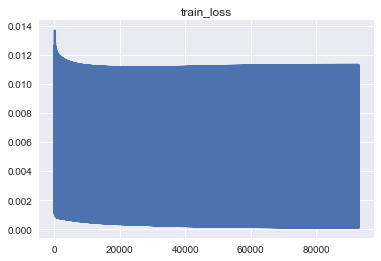

In [84]:
print(len(train_loss))
plt.plot(train_loss,'-')
plt.title('train_loss')


19530


Text(0.5,1,'test_loss')

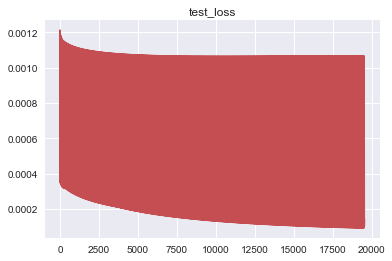

In [85]:
print(len(test_loss))
plt.plot(test_loss,'r')
plt.title('test_loss')


#### Demornamization

In [86]:
# normalized this way:
#test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [87]:
rmse = np.sqrt(mse)

In [88]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [89]:
rmse_denorm

20.074817306405894

In [90]:
#df_new_test['Kt'].sort_values()

In [91]:
df_new_test['Kt'].describe()

count    4228.000000
mean        7.648923
std        39.416136
min        -0.267460
25%        -0.007315
50%         0.016496
75%         0.905913
max      1026.823214
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [93]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss}, columns=['Train Loss'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_Boulder_1000Epoch_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss}, columns=['Test Loss'])
df_testLoss.to_csv('RNN Paper Results/Exp1_Boulder_1000EpochTestLoss.csv')